# Raw data and graphs
This pdf containts the raw data and graphs used to test the performance of the code.



## Setup 1
- Threads all increment one variable **without a mutex**

##### code

```c
// Ziad Arafat
// Created: Aug 31 2021
// Figure 1.7 in the textbook

/**
 * @brief This program will create an array of a specified size and fill it
 * with random numbers between 1 and 3 inclusive. It will then try to count
 * the number of threes in the array using a serial method and a parallel method
 * it will return the counts for each attempt as well as the running times. 
 * 
 * This version will use a single variable shared by all the threads without
 * uring a mutex. We expect it to return incorrect results
 * 
 */

/**
Changelog
08/31
- added argument handling
- Added handling to create an array of a certain size.
- added random number generator to fill array
- Created serial program to count 3s in array 

09/07
- tested thread creation using pthread
- created function to generate threads to handle different sections of array

09/10
- corrected my thread code because it wasnt being joined so output was shown
- before thread was closed.

09/11
- added timing code.

09/12
- fixed timing code. 

09/19
- added free() calls to clean up the memory when done

09/21
- fixed the way the array is split for the threads

*/

#define DEBUG 0 // flag to print debug values

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <pthread.h>

int *A; // Pointer to our array in heap
int COUNT = 0; // The count of threes we found for the parallel code
int SEGSIZE; // the size of each chunk per tread
int NUMOFTHREADS; // the number of threads to spawn
int SIZE; // The size of the input array

/**
 * @brief Iterates through a chunk of the A array and counts the number of 
 * threes by updating the COUNT variable
 * 
 * 
 * @param index The index of the array chunks re are working with
 * @return void* returns a void pointer to work with pthread
 * 
 * @pre The global A variable must be a pointer to an array in heap containing numbers between 
 * 1 and 3. index must be a number referring to the index of the chunk we want
 * to work through starting at 0. The global COUNT variable must contain the
 * number of threes we have already counted
 * 
 * @post When done the COUNT variable must be updated to have the number of 
 * threes found in our chunk of the array
 */
void *count3s(void *idx)
{
        // if (DEBUG)
        //         printf("I ran once %d\n", index);

        int *index = (int *)idx; // cast the void star input to an int ptr
        int mystart = *index * SEGSIZE; // set the starting point for the thread
        int myend = mystart + SEGSIZE; // set the end point for the thread

        if (DEBUG) {
                printf("start is %d\n", mystart);
                printf("end is   %d\n", myend);
        }

        // iterate through our section of the array and count the threes
        for (int i = mystart; i < myend; i++) {
                if (A[i] == 3) {
                        if (DEBUG)
                                printf("Found a three\n");
                        COUNT++;
                }
        }

        // When we reach the final index we will calculate the remaining values in the array
        // So that we can add them to the result.
        // This can become quite high once you go past the 50% mark of the array size
        // but our tests will never go that far so this is a pretty good solution.
        if ((myend < SIZE) && (*index == NUMOFTHREADS - 1)) {
                if (DEBUG) {
                        int remain = SIZE - myend;
                        printf("Remainder: %d \n", remain);
                }

                // printf("ACTIVE \n");

                // iterate through the remainder of the array and count the 3s
                for (int i = myend; i < SIZE; i++) {
                        if (A[i] == 3) {
                                COUNT++; // increment count
                        }
                }

                if (DEBUG) {
                        printf("The count is now %d threads %d index %d SIZE %d end %d \n",
                               COUNT, NUMOFTHREADS, *index, SIZE, myend);
                }
        }

        return (void *)0;
}

/**
 * @brief This function is used to spawn the appropriate number of threads as 
 * well as keep track of their progress. 
 * 
 * @return int containing the time it took
 * 
 * @pre The global COUNT variable is 0. NUMOFTHREADS is greater than 0.
 * SEGSIZE is the size of the array divided by NUMOFTHREADS. the A variable
 * points to an array in heap. 
 * 
 * @post The global COUNT contains the correct three count
 * 
 */
int count3s_parallel()
{
        // initialize the timer for the parallel work
        struct timespec starttime, endtime;
        int j, k;

        // get the start time
        clock_gettime(CLOCK_REALTIME, &starttime); // start the timer

        // Created an array allocated at runtime to hold the identifiers for
        // our threads
        pthread_t *t_idents;
        int *t_indices;

        // Allocates the space needed for the thread IDs
        t_idents = (pthread_t *)(malloc(sizeof(pthread_t) * NUMOFTHREADS));

        // in order to fix the "integer to pointer conversion" warning
        // i made an array to store the indices for each thread that way
        // i can pass it as a pointer in the for loop
        t_indices = (int *)(malloc(sizeof(int) * NUMOFTHREADS));

        // Create the threads
        for (int i = 0; i < NUMOFTHREADS; i++) {
                t_indices[i] = i;
                pthread_create(&t_idents[i], NULL, count3s,
                               (void *)&t_indices[i]);
        }

        // wait for all the treads to finish.
        for (int i = 0; i < NUMOFTHREADS; i++) {
                pthread_join(t_idents[i], NULL);
        }

        // free the ids and indexes in memory so we dont leak
        free(t_idents);
        free(t_indices);

        // get the end time
        clock_gettime(CLOCK_REALTIME, &endtime);

        // calculate duration
        j = endtime.tv_sec - starttime.tv_sec;
        k = endtime.tv_nsec - starttime.tv_nsec;
        j = j * 1000000000 + k;

        // return the duration
        return j;
}

int main(int argc, char const *argv[])
{
        // this variable stores the time for generating the random numbers.
        time_t t;

        // intitilize the random number with the time as the seed
        srand((unsigned)time(&t));

        // check if the correct arguments are used
        if (argc != 3) {
                // if they are wrong barf and exit
                printf("Not correct arguments \n");
                printf("Usage %s <size of array> <number of threads> \n",
                       argv[0]);
                exit(1);
        }

        // Convert the user input to integers
        SIZE = atoi(argv[1]);
        NUMOFTHREADS = atoi(argv[2]);

        // Set the size of the array chunks to process to the size over the
        // number of threads
        SEGSIZE = SIZE / NUMOFTHREADS;

        if (DEBUG) {
                printf("number is %s \n", argv[1]);
                printf("number is %d \n", SIZE);
                printf("NumThr is %d \n", NUMOFTHREADS);
                printf("Seg Size is %d \n", SEGSIZE);
        }

        // Allocate the array based on the input size
        A = (int *)(malloc(sizeof(int) * SIZE));

        // if the array is null barf
        if (A == NULL) {
                printf("Austin, we have a problem");
                exit(1);
        }

        // generate random numbers and fill them in the array
        // the numbers are between 1 and 3 inclusive
        for (int i = 0; i < SIZE; i++) {
                A[i] = rand() % 4;
                // printf("E%d \n", A[i]);
        }

        // Count the threes in parallel
        int parallel_time = count3s_parallel();

        // initialize the count for the serial code
        int local_count = 0;

        // initialize the timer for the parallel work
        struct timespec starttime, endtime;
        int j, k;

        clock_gettime(CLOCK_REALTIME, &starttime); // start the timer

        // Count the threes in serial
        for (int i = 0; i < SIZE; i++) {
                if (A[i] == 3) {
                        local_count++;
                }
        }

        // get end time
        clock_gettime(CLOCK_REALTIME, &endtime);

        // calculate duration
        j = endtime.tv_sec - starttime.tv_sec;
        k = endtime.tv_nsec - starttime.tv_nsec;
        j = j * 1000000000 + k;

        // free the array
        free(A);

        // print the times and counts
        printf("Time parallel: %d \n", parallel_time);
        printf("Time serial:   %d \n", j);

        printf("parallel count is %d\n", COUNT);
        printf("serial count is   %d\n", local_count);

        return 0;
}



```

#### Raw console outputs

- All runs are done with an array of size $10,000,000$

##### 1 Thread

```bash
doge@godemperordoge1998 ~/D/parallel-programming (main)> cd figure1_7/
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> make
gcc -O0 -Wall -Werror -Wextra -pedantic -pthread -o figure1_7 figure1_7.c
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 1
Time parallel: 41548092 
Time serial:   40781794 
parallel count is 2499294
serial count is   2499294
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 1
Time parallel: 41616537 
Time serial:   40523451 
parallel count is 2499311
serial count is   2499311
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 1
Time parallel: 41686727 
Time serial:   40876149 
parallel count is 2498476
serial count is   2498476
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 1
Time parallel: 40781165 
Time serial:   40663692 
parallel count is 2501086
serial count is   2501086
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 1
Time parallel: 42017216 
Time serial:   40238289 
parallel count is 2499818
serial count is   2499818
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> 

```

##### 2 Threads

- Since the output was not the same for parallel likely due to the race condition caused by line 85 we will stop testing this code

```bash
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 2
Time parallel: 62501107 
Time serial:   39678580 
parallel count is 2186343
serial count is   2499866
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 2
Time parallel: 61941468 
Time serial:   40740028 
parallel count is 2185462
serial count is   2498949
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 2
Time parallel: 41536079 
Time serial:   41486353 
parallel count is 2300733
serial count is   2499709
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 2
Time parallel: 62254078 
Time serial:   40387819 
parallel count is 2180401
serial count is   2499807
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> ./figure1_7 10000000 2
Time parallel: 62037290 
Time serial:   40656079 
parallel count is 2184139
serial count is   2499412
doge@godemperordoge1998 ~/D/p/figure1_7 (main)> 
```


## Setup 2
- Threads all increment one variable **with a mutex**

Text(0, 0.5, 'time in 10million ms')

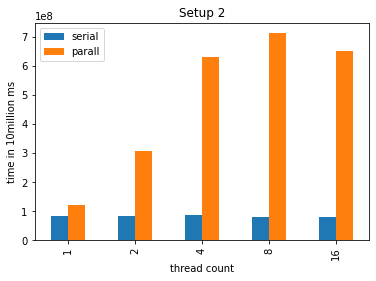

In [1]:

import matplotlib.pyplot as plt
import pandas
ser = [84013074, 81465166.2, 85934827.4, 80388688.8, 80466492]
par =  [120240643.2, 308139976, 629666501.2, 712601966.2, 651475517.6]

val_dict = {}

for k, v in enumerate(par):
        val_dict[str(2**k)]={
                "serial": ser[k],
                "parall": par[k]
        }

df1 = pandas.DataFrame.from_dict(val_dict, orient='index')



df1.plot.bar(title='Setup 2')
plt.xlabel("thread count")
plt.ylabel("time in 10million ms")





##### code
```c
// Ziad Arafat
// Created: Sep 17 2021
// Figure 1.9 in the textbook

/**
 * @brief This program will create an array of a specified size and fill it
 * with random numbers between 1 and 3 inclusive. It will then try to count
 * the number of threes in the array using a serial method and a parallel method
 * it will return the counts for each attempt as well as the running times. 
 * 
 * 
 * This version adds a mutex to prevent the race condition. We expect the 
 * the outputs to be correct but the performance will be very bad because
 * the threads will all be waiting on each other and locking/unlocking the
 * mutex causing an overhead with the OS.
 */

/**
Changelog

09/17
- Copied code from the figure1_7.c
- added mutux initializer
- added lock and unlock to the thread function


09/19
- added free() calls to clean up the memory when done

09/21
- fixed the way the array is split for the threads


*/

#define DEBUG 0 // flag to print debug values

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <pthread.h>

int *A; // Pointer to our array in heap
int COUNT = 0; // The count of threes we found for the parallel code
int SEGSIZE; // the size of each chunk per tread
int NUMOFTHREADS; // the number of threads to spawn
int SIZE; // The size of the input array

pthread_mutex_t mtex = PTHREAD_MUTEX_INITIALIZER; // this is our mutex variable

/**
 * @brief Iterates through a chunk of the A array and counts the number of 
 * threes by updating the COUNT variable
 * 
 * 
 * @param index The index of the array chunks re are working with
 * @return void* returns a void pointer to work with pthread
 * 
 * @pre The global A variable must be a pointer to an array in heap containing numbers between 
 * 1 and 3. index must be a number referring to the index of the chunk we want
 * to work through starting at 0. The global COUNT variable must contain the
 * number of threes we have already counted
 * 
 * @post When done the COUNT variable must be updated to have the number of 
 * threes found in our chunk of the array
 */
void *count3s(void *idx)
{
        // if (DEBUG)
        //         printf("I ran once %d\n", index);

        int *index = (int *)idx; // cast the void star input to an int ptr
        int mystart = *index * SEGSIZE; // set the starting point for the thread
        int myend = mystart + SEGSIZE; // set the end point for the thread

        if (DEBUG) {
                printf("start is %d\n", mystart);
                printf("end is   %d\n", myend);
        }

        // iterate through our section of the array and count the threes
        for (int i = mystart; i < myend; i++) {
                if (A[i] == 3) {
                        if (DEBUG) {
                                printf("Found a three\n");
                        }

                        // lock the mutex thereby waiting until other threads
                        // are done with this section of the code before
                        // locking it.
                        pthread_mutex_lock(&mtex); // lock the mutex

                        COUNT++; // increment count

                        // unlock the mutex to let the OS know we are done
                        // with this section of code.
                        pthread_mutex_unlock(&mtex);
                }
        }

        // When we reach the final index we will calculate the remaining values in the array
        // So that we can add them to the result.
        // This can become quite high once you go past the 50% mark of the array size
        // but our tests will never go that far so this is a pretty good solution.
        if ((myend < SIZE) && (*index == NUMOFTHREADS - 1)) {
                if (DEBUG) {
                        int remain = SIZE - myend;
                        printf("Remainder: %d \n", remain);
                }

                // iterate through the remainder of the array and count the 3s
                for (int i = myend; i < SIZE; i++) {
                        // if its a three in the array
                        if (A[i] == 3) {
                                // lock the mutex thereby waiting until other threads
                                // are done with this section of the code before
                                // locking it.
                                pthread_mutex_lock(&mtex); // lock the mutex

                                COUNT++; // increment count

                                // unlock the mutex to let the OS know we are done
                                // with this section of code.
                                pthread_mutex_unlock(&mtex);
                        }
                }

                if (DEBUG) {
                        printf("The count is now %d threads %d index %d SIZE %d end %d \n",
                               COUNT, NUMOFTHREADS, *index, SIZE, myend);
                }
        }

        return (void *)0;
}

/**
 * @brief This function is used to spawn the appropriate number of threads
 * 
 * @return int containing the time it took
 * 
 * @pre The global COUNT variable is 0. NUMOFTHREADS is greater than 0.
 * SEGSIZE is the size of the array divided by NUMOFTHREADS. the A variable
 * points to an array in heap. 
 * 
 * @post The global COUNT contains the correct three count
 * 
 */
int count3s_parallel()
{
        // initialize the timer for the parallel work
        struct timespec starttime, endtime;
        int j, k;

        // get the start time
        clock_gettime(CLOCK_REALTIME, &starttime); // start the timer

        // Created an array allocated at runtime to hold the identifiers for
        // our threads
        pthread_t *t_idents;
        int *t_indices;

        // Allocates the space needed for the thread IDs
        t_idents = (pthread_t *)(malloc(sizeof(pthread_t) * NUMOFTHREADS));

        // in order to fix the "integer to pointer conversion" warning
        // i made an array to store the indices for each thread that way
        // i can pass it as a pointer in the for loop
        t_indices = (int *)(malloc(sizeof(int) * NUMOFTHREADS));

        // Create the threads
        for (int i = 0; i < NUMOFTHREADS; i++) {
                t_indices[i] = i;
                pthread_create(&t_idents[i], NULL, count3s,
                               (void *)&t_indices[i]);
        }

        // wait for all the treads to finish.
        for (int i = 0; i < NUMOFTHREADS; i++) {
                pthread_join(t_idents[i], NULL);
        }

        // free the ids and indexes in memory so we dont leak
        free(t_idents);
        free(t_indices);

        // get the end time
        clock_gettime(CLOCK_REALTIME, &endtime);

        // calculate duration
        j = endtime.tv_sec - starttime.tv_sec;
        k = endtime.tv_nsec - starttime.tv_nsec;
        j = j * 1000000000 + k;

        // return the duration
        return j;
}

int main(int argc, char const *argv[])
{
        // this variable stores the time for generating the random numbers.
        time_t t;

        // intitilize the random number with the time as the seed
        srand((unsigned)time(&t));


        // check the user arguments
        if (argc != 3) {
                // if they are wrong count barf
                printf("Not correct arguments \n");
                printf("Usage %s <size of array> <numbe>r of threads> \n",
                       argv[0]);
                exit(1);
        }

        // Convert the user input to integers
        SIZE = atoi(argv[1]);
        NUMOFTHREADS = atoi(argv[2]);

        // Set the size of the array chunks to process to the size over the
        // number of threads
        SEGSIZE = SIZE / NUMOFTHREADS;

        if (DEBUG) {
                printf("number is %s \n", argv[1]);
                printf("number is %d \n", SIZE);
                printf("NumThr is %d \n", NUMOFTHREADS);
                printf("Seg Size is %d \n", SEGSIZE);
        }

        // Allocate the array based on the input size
        A = (int *)(malloc(sizeof(int) * SIZE));

        // if the array is null barf
        if (A == NULL) {
                perror("Austin, we have a problem");
                // printf("Austin, we have a problem");
                exit(1);
        }

        // generate random numbers and fill them in the array
        // the numbers are between 1 and 3 inclusive
        for (int i = 0; i < SIZE; i++) {
                A[i] = rand() % 4;

                // printf("E%d \n", A[i]);
        }

        // Count the threes in parallel
        int parallel_time = count3s_parallel();

        // since the COUNT for the parallel is defined before starting the
        // timer i choose to define this one before timer as well.
        int local_count = 0;

        // initialize the timer for the parallel work
        struct timespec starttime, endtime;
        int j, k;
        clock_gettime(CLOCK_REALTIME, &starttime); // start the timer

        // Count the threes in serial
        for (int i = 0; i < SIZE; i++) {
                if (A[i] == 3) {
                        local_count++;
                }
        }

        // get end time
        clock_gettime(CLOCK_REALTIME, &endtime);

        // calculate duration
        j = endtime.tv_sec - starttime.tv_sec;
        k = endtime.tv_nsec - starttime.tv_nsec;
        j = j * 1000000000 + k;

        // free the array
        free(A);

        // print the times and counts
        printf("Time parallel: %d \n", parallel_time);
        printf("Time serial:   %d \n", j);

        printf("parallel count is %d\n", COUNT);
        printf("serial count is   %d\n", local_count);

        return 0;
}


```

#### Raw console outputs
##### 1 Thread

```bash
doge@godemperordoge1998 ~/D/p/withmutex (main)> make
gcc -O0 -Wall -Werror -Wextra -pedantic -pthread -lpthread -o withmutex withmutex.c
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 1
Time parallel: 120021411 
Time serial:   78854234 
parallel count is 2501472
serial count is   2501472
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 1
Time parallel: 120497170 
Time serial:   81333878 
parallel count is 2499989
serial count is   2499989
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 1
Time parallel: 120347221 
Time serial:   87031321 
parallel count is 2501315
serial count is   2501315
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 1
Time parallel: 120116256 
Time serial:   78876653 
parallel count is 2501360
serial count is   2501360
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 1
Time parallel: 120221158 
Time serial:   93969284 
parallel count is 2501360
serial count is   2501360
doge@godemperordoge1998 ~/D/p/withmutex (main)> 
```

##### 2 Threads

```bash
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 2
Time parallel: 278855092 
Time serial:   81221853 
parallel count is 2499954
serial count is   2499954
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 2
Time parallel: 315544116 
Time serial:   89160223 
parallel count is 2501195
serial count is   2501195
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 2
Time parallel: 309496769 
Time serial:   79645116 
parallel count is 2499936
serial count is   2499936
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 2
Time parallel: 310133511 
Time serial:   78546513 
parallel count is 2499456
serial count is   2499456
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 2
Time parallel: 326670392 
Time serial:   78752126 
parallel count is 2500418
serial count is   2500418
doge@godemperordoge1998 ~/D/p/withmutex (main)> 

```

##### 4 threads

```bash
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 4
Time parallel: 621104281 
Time serial:   78621872 
parallel count is 2500078
serial count is   2500078
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 4
Time parallel: 628150499 
Time serial:   92534186 
parallel count is 2499876
serial count is   2499876
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 4
Time parallel: 612589789 
Time serial:   88590668 
parallel count is 2498990
serial count is   2498990
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 4
Time parallel: 631838048 
Time serial:   78806044 
parallel count is 2501489
serial count is   2501489
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 4
Time parallel: 654649889 
Time serial:   91121367 
parallel count is 2499659
serial count is   2499659
doge@godemperordoge1998 ~/D/p/withmutex (main)> 
```

##### 8 threads

```bash
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 8
Time parallel: 735814192 
Time serial:   78948171 
parallel count is 2500200
serial count is   2500200
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 8
Time parallel: 637441065 
Time serial:   83372267 
parallel count is 2500024
serial count is   2500024
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 8
Time parallel: 733727894 
Time serial:   78821827 
parallel count is 2502801
serial count is   2502801
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 8
Time parallel: 715607851 
Time serial:   79105103 
parallel count is 2501713
serial count is   2501713
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 8
Time parallel: 740418829 
Time serial:   81696076 
parallel count is 2500349
serial count is   2500349
doge@godemperordoge1998 ~/D/p/withmutex (main)> 

```

##### 16 threads

```bash
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 16
Time parallel: 670948609 
Time serial:   78550634 
parallel count is 2497839
serial count is   2497839
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 16
Time parallel: 669674494 
Time serial:   78881891 
parallel count is 2500331
serial count is   2500331
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 16
Time parallel: 606297090 
Time serial:   82304114 
parallel count is 2501547
serial count is   2501547
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 16
Time parallel: 677565931 
Time serial:   83745498 
parallel count is 2499270
serial count is   2499270
doge@godemperordoge1998 ~/D/p/withmutex (main)> ./withmutex 10000000 16
Time parallel: 632891464 
Time serial:   78850323 
parallel count is 2502719
serial count is   2502719
doge@godemperordoge1998 ~/D/p/withmutex (main)> 
```



## Setup 3
- Each thread increments it's own count variable in an array **without padding**

Text(0, 0.5, 'time in 10million ms')

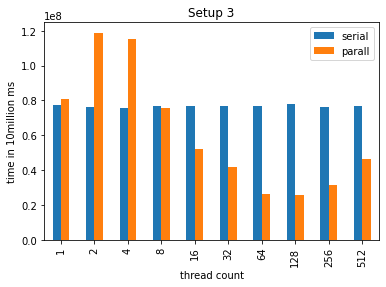

In [2]:
ser =  [77342337.6, 76163542.4, 75757667, 76600539.4, 76741758.4, 76538017.4, 76620890.8, 77830947.6, 76217962.6, 76562336.2]
par =  [80784200.2, 118902330.6, 115032536.8, 75653505.8, 51827737.4, 41478460.2, 26468548.4, 25685669.4, 31348666.2, 46536505.8]

val_dict = {}

for k, v in enumerate(par):
        val_dict[str(2**k)]={
                "serial": ser[k],
                "parall": par[k]
        }

df1 = pandas.DataFrame.from_dict(val_dict, orient='index')



df1.plot.bar(title='Setup 3')
plt.xlabel("thread count")
plt.ylabel("time in 10million ms")





##### code
```c
// Ziad Arafat
// Created: sep 18 2021
// Figure 1.10 in the textbook

/**
 * @brief This program will create an array of a specified size and fill it
 * with random numbers between 1 and 3 inclusive. It will then try to count
 * the number of threes in the array using a serial method and a parallel method
 * it will return the counts for each attempt as well as the running times. 
 * 
 */

/**
Changelog
09/17
- Copied code from the withmutex.c code
- added dynamic array allocation for the results of the threads
- removed the mutex lock and unlock
- modified the thread to indrement the corresponding item in the array instead of global count


09/19
- added free() calls to clean up the memory when done

09/21
- fixed the way the array is split for the threads


*/

#define DEBUG 0 // flag to print debug values

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <pthread.h>

int *A; // Pointer to our array in heap
int COUNT = 0; // The count of threes we found for the parallel code
int SEGSIZE; // the size of each chunk per tread
int NUMOFTHREADS; // the number of threads to spawn
int *t_results; // an array to store the results from each thread
int SIZE; // The size of the array

pthread_mutex_t mtex = PTHREAD_MUTEX_INITIALIZER; // this is our mutex variable

/**
 * @brief Iterates through a chunk of the A array and counts the number of 
 * threes by updating an item in a results array corresponding to the thread.
 * 
 * 
 * @param index The index of the array chunks re are working with
 * @return void* returns a void pointer to work with pthread
 * 
 * @pre The global A variable must be a pointer to an array in heap containing numbers between 
 * 1 and 3. index must be a number referring to the index of the chunk we want
 * to work through starting at 0. The global t_results array must be 0 at the
 * corresponding index 
 * 
 * @post When done the array element corresponding to the thread must have the 
 * number of threes we found in our chunk of the array
 */
void *count3s(void *idx)
{
        int *index = (int *)idx; // cast the void star input to an int ptr
        int mystart = *index * SEGSIZE; // set the starting point for the thread
        int myend = mystart + SEGSIZE; // set the end point for the thread

        if (DEBUG) {
                printf("I ran once %d\n", *index);
        }

        if (DEBUG) {
                printf("start is %d\n", mystart);
                printf("end is   %d\n", myend);
        }

        // iterate through our chunk and increment our array element when a
        // three is found
        for (int i = mystart; i < myend; i++) {
                if (A[i] == 3) {
                        t_results[*index]++; // increment result
                }
        }

        // printf("Threads %d index %d size %d END %d \n", NUMOFTHREADS, *index, SIZE, myend);

        // When we reach the final index we will calculate the remaining values in the array
        // So that we can add them to the result.
        // This can become quite high once you go past the 50% mark of the array size
        // but our tests will never go that far so this is a pretty good solution.
        if ((myend < SIZE) && (*index == NUMOFTHREADS - 1)) {
                if (DEBUG) {
                        int remain = SIZE - myend;
                        printf("Remainder: %d \n", remain);
                }

                // iterate through the remainder of the array and count the 3s
                for (int i = myend; i < SIZE; i++) {
                        if (A[i] == 3) {
                                t_results[*index]++;
                        }
                }
        }

        return (void *)0;
}

/**
 * @brief This function is used to spawn the appropriate number of threads and 
 * also gathers the results of each thread and sums them.
 * 
 * @return int containing the time it took
 * 
 * @pre Global COUNT is 0. NUMOFTHREADS is greater than 0.
 * SEGSIZE is the size of the array divided by NUMOFTHREADS. the A variable
 * points to an array in heap. 
 * 
 * @post The global COUNT contains the correct three count
 * 
 */
int count3s_parallel()
{
        // initialize the timer for the parallel work
        struct timespec starttime, endtime;
        int j, k;

        // get the start time
        clock_gettime(CLOCK_REALTIME, &starttime); // start the timer

        // Created an array allocated at runtime to hold the identifiers for
        // our threads
        pthread_t *t_idents;
        int *t_indices;

        // Allocates the space needed for the thread IDs
        t_idents = (pthread_t *)(malloc(sizeof(pthread_t) * NUMOFTHREADS));

        // in order to fix the "integer to pointer conversion" warning
        // i made an array to store the indices for each thread that way
        // i can pass it as a pointer in the for loop
        t_indices = (int *)(malloc(sizeof(int) * NUMOFTHREADS));

        // allocate an array of ints to store the results.
        t_results = (int *)(calloc(NUMOFTHREADS, sizeof(int) * NUMOFTHREADS));

        // Create the threads
        for (int i = 0; i < NUMOFTHREADS; i++) {
                t_indices[i] = i;
                pthread_create(&t_idents[i], NULL, count3s,
                               (void *)&t_indices[i]);
        }

        // wait for all the treads to finish.
        for (int i = 0; i < NUMOFTHREADS; i++) {
                pthread_join(t_idents[i], NULL);
                COUNT += t_results[i];
        }

        // free the three arrays we made so we dont leak.
        free(t_idents);
        free(t_indices);
        free(t_results);

        // get the end time
        clock_gettime(CLOCK_REALTIME, &endtime);

        // calculate duration
        j = endtime.tv_sec - starttime.tv_sec;
        k = endtime.tv_nsec - starttime.tv_nsec;
        j = j * 1000000000 + k;

        // return the duration
        return j;
}

int main(int argc, char const *argv[])
{
        // this variable stores the time for generating the random numbers.
        time_t t;

        // intitilize the random number with the time as the seed
        srand((unsigned)time(&t));

        // check the user arguments
        if (argc != 3) {
                // if they are wrong count barf
                printf("Not correct arguments \n");
                printf("Usage %s <size of array> <numbe>r of threads> \n",
                       argv[0]);
                exit(1);
        }

        // Convert the user input to integers
        SIZE = atoi(argv[1]);
        NUMOFTHREADS = atoi(argv[2]);

        // Set the size of the array chunks to process to the size over the
        // number of threads
        SEGSIZE = SIZE / NUMOFTHREADS;

        if (DEBUG) {
                printf("number is %s \n", argv[1]);
                printf("number is %d \n", SIZE);
                printf("NumThr is %d \n", NUMOFTHREADS);
                printf("Seg Size is %d \n", SEGSIZE);
        }

        // Allocate the array based on the input size
        A = (int *)(malloc(sizeof(int) * SIZE));

        // if the array is null barf
        if (A == NULL) {
                // printf("Austin, we have a problem");
                perror("Austin, we have a problem");
                exit(1);
        }

        // generate random numbers and fill them in the array
        // the numbers are between 1 and 3 inclusive
        for (int i = 0; i < SIZE; i++) {
                // if we are debugging lets make them all threes.
                // that way we can tell if something isnt
                // being counted.
                if (DEBUG) {
                        A[i] = 3;
                } else {
                        A[i] = rand() % 4;
                }
        }

        // Count the threes in parallel
        int parallel_time = count3s_parallel();

        // since the COUNT for the parallel is defined before starting the
        // timer i choose to define this one before timer as well.
        int local_count = 0;

        // initialize the timer for the parallel work
        struct timespec starttime, endtime;
        int j, k;
        clock_gettime(CLOCK_REALTIME, &starttime); // start the timer

        // Count the threes in serial
        for (int i = 0; i < SIZE; i++) {
                if (A[i] == 3) {
                        local_count++;
                }
        }

        // get end time
        clock_gettime(CLOCK_REALTIME, &endtime);

        // calculate duration
        j = endtime.tv_sec - starttime.tv_sec;
        k = endtime.tv_nsec - starttime.tv_nsec;
        j = j * 1000000000 + k;

        // free the array
        free(A);

        // print the times and counts
        printf("Time parallel: %d \n", parallel_time);
        printf("Time serial:   %d \n", j);

        printf("parallel count is %d\n", COUNT);
        printf("serial count is   %d\n", local_count);

        if (DEBUG) {
                printf("SEGSIZE %d \n", SEGSIZE);
        }

        return 0;
}


```

#### Raw console outputs

##### 1 Thread

```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> make
gcc -O0 -Wall -Werror -Wextra -pedantic -pthread -lpthread -o witharray witharray.c
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 1
Time parallel: 81863555 
Time serial:   75568341 
parallel count is 2500620
serial count is   2500620
SEGSIZE 10000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 1
Time parallel: 79677104 
Time serial:   75715147 
parallel count is 2499935
serial count is   2499935
SEGSIZE 10000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 1
Time parallel: 80084768 
Time serial:   76378151 
parallel count is 2498190
serial count is   2498190
SEGSIZE 10000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 1
Time parallel: 83075721 
Time serial:   78784952 
parallel count is 2499420
serial count is   2499420
SEGSIZE 10000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 1
Time parallel: 79219853 
Time serial:   80265097 
parallel count is 2503792
serial count is   2503792
SEGSIZE 10000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> 
```

##### 2 Threads

```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 2
^[[ATime parallel: 117217005 
Time serial:   76232392 
parallel count is 2500931
serial count is   2500931
SEGSIZE 5000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 2
Time parallel: 117227900 
Time serial:   75723948 
parallel count is 2499572
serial count is   2499572
SEGSIZE 5000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 2
Time parallel: 125809927 
Time serial:   76198239 
parallel count is 2499572
serial count is   2499572
SEGSIZE 5000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 2
^[[A
Time parallel: 117415982 
Time serial:   76056322 
parallel count is 2497775
serial count is   2497775
SEGSIZE 5000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 2
Time parallel: 116840839 
Time serial:   76606811 
parallel count is 2497775
serial count is   2497775
SEGSIZE 5000000 
doge@godemperordoge1998 ~/D/p/witharray (main)> 
```

##### 4 Threads

```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 4
Time parallel: 119560039 
Time serial:   75835135 
parallel count is 2498552
serial count is   2498552
SEGSIZE 2500000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 4
Time parallel: 110999175 
Time serial:   75637135 
parallel count is 2502155
serial count is   2502155
SEGSIZE 2500000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 4
Time parallel: 120659063 
Time serial:   75797630 
parallel count is 2502155
serial count is   2502155
SEGSIZE 2500000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 4
Time parallel: 105918640 
Time serial:   75691681 
parallel count is 2500763
serial count is   2500763
SEGSIZE 2500000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 4
Time parallel: 118025767 
Time serial:   75826754 
parallel count is 2501575
serial count is   2501575
SEGSIZE 2500000 
doge@godemperordoge1998 ~/D/p/witharray (main)> 

```

##### 8 Threads

```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 8
Time parallel: 75531675 
Time serial:   76051224 
parallel count is 2500300
serial count is   2500300
SEGSIZE 1250000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 8
Time parallel: 75182817 
Time serial:   75753420 
parallel count is 2499436
serial count is   2499436
SEGSIZE 1250000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 8
Time parallel: 76046405 
Time serial:   76348748 
parallel count is 2501044
serial count is   2501044
SEGSIZE 1250000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 8
Time parallel: 75545853 
Time serial:   76008551 
parallel count is 2499779
serial count is   2499779
SEGSIZE 1250000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 8
Time parallel: 75960779 
Time serial:   78840754 
parallel count is 2499779
serial count is   2499779
SEGSIZE 1250000 
doge@godemperordoge1998 ~/D/p/witharray (main)> 

```

##### 16 threads

```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 16
Time parallel: 51618507 
Time serial:   79680457 
parallel count is 2500182
serial count is   2500182
SEGSIZE 625000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 16
Time parallel: 52043701 
Time serial:   75934658 
parallel count is 2502307
serial count is   2502307
SEGSIZE 625000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 16
Time parallel: 51582748 
Time serial:   75689934 
parallel count is 2499453
serial count is   2499453
SEGSIZE 625000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 16
Time parallel: 52321250 
Time serial:   76262634 
parallel count is 2499453
serial count is   2499453
SEGSIZE 625000 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 16
Time parallel: 51572481 
Time serial:   76141109 
parallel count is 2498729
serial count is   2498729
SEGSIZE 625000 
doge@godemperordoge1998 ~/D/p/witharray (main)> 

```

##### 32 threads
```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 32
Time parallel: 52033155 
Time serial:   75630360 
parallel count is 2502265
serial count is   2502265
SEGSIZE 312500 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 32
Time parallel: 40560746 
Time serial:   75752932 
parallel count is 2496956
serial count is   2496956
SEGSIZE 312500 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 32
Time parallel: 33518090 
Time serial:   79269021 
parallel count is 2499218
serial count is   2499218
SEGSIZE 312500 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 32
Time parallel: 42830797 
Time serial:   75999611 
parallel count is 2499218
serial count is   2499218
SEGSIZE 312500 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 32
Time parallel: 38449513 
Time serial:   76038163 
parallel count is 2498024
serial count is   2498024
SEGSIZE 312500 
doge@godemperordoge1998 ~/D/p/witharray (main)> 
```

##### 64 threads

```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 64
Time parallel: 23108945 
Time serial:   76429135 
parallel count is 2501086
serial count is   2501086
SEGSIZE 156250 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 64
Time parallel: 32038014 
Time serial:   78676976 
parallel count is 2501086
serial count is   2501086
SEGSIZE 156250 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 64
Time parallel: 29387118 
Time serial:   75795394 
parallel count is 2499983
serial count is   2499983
SEGSIZE 156250 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 64
Time parallel: 21765129 
Time serial:   75698106 
parallel count is 2499590
serial count is   2499590
SEGSIZE 156250 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 64
Time parallel: 26043536 
Time serial:   76504843 
parallel count is 2499590
serial count is   2499590
SEGSIZE 156250 
doge@godemperordoge1998 ~/D/p/witharray (main)> 
```

##### 128 threads
```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 128
Time parallel: 27093181 
Time serial:   75747694 
parallel count is 2499556
serial count is   2499556
SEGSIZE 78125 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 128
Time parallel: 23288786 
Time serial:   76220100 
parallel count is 2501938
serial count is   2501938
SEGSIZE 78125 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 128
Time parallel: 28004540 
Time serial:   84610064 
parallel count is 2498595
serial count is   2498595
SEGSIZE 78125 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 128
Time parallel: 24022050 
Time serial:   76480189 
parallel count is 2498595
serial count is   2498595
SEGSIZE 78125 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000 128
Time parallel: 26019790 
Time serial:   76096691 
parallel count is 2500116
serial count is   2500116
SEGSIZE 78125 
doge@godemperordoge1998 ~/D/p/witharray (main)> 
```


##### 256 threads
```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  256
Time parallel: 30797702 
Time serial:   76585020 
parallel count is 2500664
serial count is   2500664
SEGSIZE 39062 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  256
Time parallel: 30520153 
Time serial:   76308938 
parallel count is 2502137
serial count is   2502137
SEGSIZE 39062 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  256
Time parallel: 29454864 
Time serial:   76265916 
parallel count is 2501344
serial count is   2501344
SEGSIZE 39062 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  256
Time parallel: 32954541 
Time serial:   76108284 
parallel count is 2498982
serial count is   2498982
SEGSIZE 39062 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  256
Time parallel: 33016071 
Time serial:   75821655 
parallel count is 2498982
serial count is   2498982
SEGSIZE 39062 
doge@godemperordoge1998 ~/D/p/witharray (main)> 
```

##### 512 Threads

```bash
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  512
^[[ATime parallel: 48074062 
Time serial:   76889948 
parallel count is 2503817
serial count is   2503817
SEGSIZE 19531 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  512
Time parallel: 44829655 
Time serial:   76344138 
parallel count is 2500075
serial count is   2500075
SEGSIZE 19531 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  512
Time parallel: 45507953 
Time serial:   75874944 
parallel count is 2500075
serial count is   2500075
SEGSIZE 19531 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  512
Time parallel: 49365148 
Time serial:   76632722 
parallel count is 2499084
serial count is   2499084
SEGSIZE 19531 
doge@godemperordoge1998 ~/D/p/witharray (main)> ./witharray 10000000  512
Time parallel: 44905711 
Time serial:   77069929 
parallel count is 2499084
serial count is   2499084
SEGSIZE 19531 
doge@godemperordoge1998 ~/D/p/witharray (main)> 


```


## Setup 4
- Each thread increments it's own count variable in an array **with padding**

##### Raw Data Processing and Graphing

Text(0, 0.5, 'time in 10million ms')

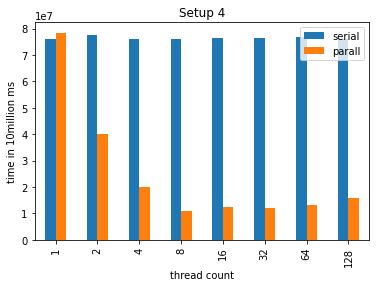

In [3]:
# Data Processing

ser =  [76142799.4, 77717943.8, 76086493.6, 76067440.6, 76296925.4, 76344599, 76862234.8, 76255383.8]
par =  [78454322.4, 40209206.6, 20134348.6, 10790813.6, 12481699.4, 12199778.2, 13109907.8, 15661670.6]

val_dict = {}

for k, v in enumerate(par):
        val_dict[str(2**k)]={
                "serial": ser[k],
                "parall": par[k]
        }

df1 = pandas.DataFrame.from_dict(val_dict, orient='index')



df1.plot.bar(title='Setup 4')
plt.xlabel("thread count")
plt.ylabel("time in 10million ms")



##### code
```c
// Ziad Arafat
// Created: Sep 19 2021
// Figure 1.11 in the textbook

/**
 * @brief This program will create an array of a specified size and fill it
 * with random numbers between 1 and 3 inclusive. It will then try to count
 * the number of threes in the array using a serial method and a parallel method
 * it will return the counts for each attempt as well as the running times. 
 * 
 * In this version we will create a struct called padded_int which will contain
 * the count as well as a padding of chars set to fill up the chache line of 
 * the maching we run it on.
 */

/**
Changelog

09/18
- copied code from witharray.c
- created the struct padded_int with the appropriate char padding
- modified the results array to be an array of our padded_int
- modified the thread to correctly access and increment the padded_ints
- 

9/19
- added free() calls to clean up the memory when done

09/21
- fixed the way the array is split for the threads by making the size global

BUGFIX: The way the array was bieng split was incorrect because unless the array
size was a multiple of the thread count there would be a remaining chunk of
the array. In fact if the thread count is more than half the array size this
chunk could be massive. The fix involved adding an extra loop that gathered the
remaining array elements on the last run. I feel like there is a more elegant
solution but this seems to work well for the purpose of this program? 

*/

#define DEBUG 0 // flag to print debug values

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <pthread.h>

int *A; // Pointer to our array in heap
int COUNT = 0; // The count of threes we found for the parallel code
int SEGSIZE; // the size of each chunk per tread
int NUMOFTHREADS; // the number of threads to spawn
int SIZE; // size of the array

// This is a struct that will hold our data in the array for padding.
struct padded_int {
        // We need 64B of padding. Because our processor has 64B cache lines
        int value; // an int is 4 bytes
        char padding[60]; // now we need 64-4 more bytes so we make 60 chars
};

struct padded_int *t_results; // an array to store the results from each thread

pthread_mutex_t mtex = PTHREAD_MUTEX_INITIALIZER; // this is our mutex variable

/**
 * @brief Iterates through a chunk of the A array and counts the number of 
 * threes by updating the COUNT variable
 * 
 * 
 * @param index The index of the array chunks re are working with
 * @return void* returns a void pointer to work with pthread
 * 
 * @pre The global A variable must be a pointer to an array in heap containing numbers between 
 * 1 and 3. index must be a number referring to the index of the chunk we want
 * to work through starting at 0. The global COUNT variable must contain the
 * number of threes we have already counted
 * 
 * @post When done the value attribute of the padded int in the array element 
 * corresponding to the thread must have the correct number of threes we found
 * in our chunk of the array
 */
void *count3s(void *idx)
{
        int *index = (int *)idx; // cast the void star input to an int ptr
        int mystart = *index * SEGSIZE; // set the starting point for the thread
        int myend = mystart + SEGSIZE; // set the end point for the thread

        if (DEBUG) {
                printf("I ran once %d\n", *index);
        }
        
        // this temporary variable is here because i am scared of pointers and
        // structs so this just makes sure i dont break things.
        int valueforthread = 0;

        if (DEBUG) {
                printf("start is %d\n", mystart);
                printf("end is   %d\n", myend);
        }

        for (int i = mystart; i < myend; i++) {
                if (A[i] == 3) {
                        valueforthread++; // increment result
                }
        }

        // When we reach the final index we will calculate the remaining values in the array
        // So that we can add them to the result.
        // This can become quite high once you go past the 50% mark of the array size
        // but our tests will never go that far so this is a pretty good solution.
        if ((myend < SIZE) && (*index == NUMOFTHREADS - 1)) {
                // int remain = SIZE - myend;
                // printf("Remainder: %d \n", remain);
                // printf("ACTIVE \n");
                for (int i = myend; i < SIZE; i++) {
                        if (A[i] == 3) {
                                valueforthread++;
                        }
                }
        }

        if (DEBUG) {
                printf("value counted: %d \n", valueforthread);
        }

        // I am once again scared of pointers so i manually set it to 0
        // and add on the value.
        t_results[*index].value = 0;
        t_results[*index].value += valueforthread;

        return (void *)0;
}

/**
 * @brief This function is used to spawn the appropriate number of threads and
 * also gathers the results of each thread and sums them.
 * 
 * @return int containing the time it took
 * 
 * @pre The global COUNT variable is 0. NUMOFTHREADS is greater than 0.
 * SEGSIZE is the size of the array divided by NUMOFTHREADS. the A variable
 * points to an array in heap. 
 * 
 * @post The global COUNT contains the correct three count
 * 
 */
int count3s_parallel()
{
        // initialize the timer for the parallel work
        struct timespec starttime, endtime;
        int j, k;

        // get the start time
        clock_gettime(CLOCK_REALTIME, &starttime); // start the timer

        // Created an array allocated at runtime to hold the identifiers for
        // our threads
        pthread_t *t_idents;
        int *t_indices;

        // Allocates the space needed for the thread IDs
        t_idents = (pthread_t *)(malloc(sizeof(pthread_t) * NUMOFTHREADS));

        // in order to fix the "integer to pointer conversion" warning
        // i made an array to store the indices for each thread that way
        // i can pass it as a pointer in the for loop
        t_indices = (int *)(malloc(sizeof(int) * NUMOFTHREADS));

        // We will initialize the padded ints manually in the thread because
        // I dont know how calloc will behave with a struct.
        t_results = (struct padded_int *)(malloc(sizeof(struct padded_int) *
                                                 NUMOFTHREADS));

        // Create the threads
        for (int i = 0; i < NUMOFTHREADS; i++) {
                t_indices[i] = i;
                pthread_create(&t_idents[i], NULL, count3s,
                               (void *)&t_indices[i]);
        }
        COUNT = 0;
        // wait for all the treads to finish.
        for (int i = 0; i < NUMOFTHREADS; i++) {
                pthread_join(t_idents[i], NULL);
                COUNT += t_results[i].value;
        }

        // free the three arrays we made so we dont leak.
        free(t_idents);
        free(t_indices);
        free(t_results);

        // get the end time
        clock_gettime(CLOCK_REALTIME, &endtime);

        // calculate duration
        j = endtime.tv_sec - starttime.tv_sec;
        k = endtime.tv_nsec - starttime.tv_nsec;
        j = j * 1000000000 + k;

        // return the duration
        return j;
}

int main(int argc, char const *argv[])
{
        // this variable stores the time for generating the random numbers.
        time_t t;

        // intitilize the random number with the time as the seed
        srand((unsigned)time(&t));

        if (argc != 3) {
                printf("Not correct arguments \n");
                printf("Usage %s <size of array> <number of threads> \n",
                       argv[0]);
                exit(1);
        }

        // Convert the user input to integers
        SIZE = atoi(argv[1]);
        NUMOFTHREADS = atoi(argv[2]);

        // Set the size of the array chunks to process to the size over the
        // number of threads
        SEGSIZE = SIZE / NUMOFTHREADS;

        if (DEBUG) {
                printf("number is %s \n", argv[1]);
                printf("number is %d \n", SIZE);
                printf("NumThr is %d \n", NUMOFTHREADS);
                printf("Seg Size is %d \n", SEGSIZE);
        }

        // Allocate the array based on the input size
        A = (int *)(malloc(sizeof(int) * SIZE));

        // if the array is null barf
        if (A == NULL) {
                // printf("Austin, we have a problem");
                perror("Austin, we have a problem");
                exit(1);
        }
        // generate random numbers and fill them in the array
        // the numbers are between 1 and 3 inclusive
        for (int i = 0; i < SIZE; i++) {
                // if we are debugging lets make them all threes.
                // that way we can tell if something isnt
                // being counted.
                if (DEBUG) {
                        A[i] = 3;
                } else {
                        A[i] = rand() % 4;
                }
        }

        // Count the threes in parallel
        int parallel_time = count3s_parallel();

        // since the COUNT for the parallel is defined before starting the
        // timer i choose to define this one before timer as well.
        int local_count = 0;

        // initialize the timer for the parallel work
        struct timespec starttime, endtime;
        int j, k;
        clock_gettime(CLOCK_REALTIME, &starttime); // start the timer

        // Count the threes in serial
        for (int i = 0; i < SIZE; i++) {
                if (A[i] == 3) {
                        local_count++;
                }
        }

        // get end time
        clock_gettime(CLOCK_REALTIME, &endtime);

        // calculate duration
        j = endtime.tv_sec - starttime.tv_sec;
        k = endtime.tv_nsec - starttime.tv_nsec;
        j = j * 1000000000 + k;

        // free the array
        free(A);

        // print the times and counts
        printf("Time parallel: %d \n", parallel_time);
        printf("Time serial:   %d \n", j);

        printf("parallel count is %d\n", COUNT);
        printf("serial count is   %d\n", local_count);

        return 0;
}


```

#### Raw console outputs

##### 1 Thread

```bash
doge@godemperordoge1998 ~/D/p/padded (main)> make
gcc -O0 -Wall -Werror -Wextra -pedantic -pthread -lpthread -o padded padded.c
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 1
Time parallel: 79589173 
Time serial:   76582925 
parallel count is 2499295
serial count is   2499295
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 1
Time parallel: 77817021 
Time serial:   76191186 
parallel count is 2501600
serial count is   2501600
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 1
Time parallel: 78369396 
Time serial:   76075458 
parallel count is 2501212
serial count is   2501212
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 1
Time parallel: 77878131 
Time serial:   75789878 
parallel count is 2497788
serial count is   2497788
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 1
Time parallel: 78617891 
Time serial:   76074550 
parallel count is 2499979
serial count is   2499979
doge@godemperordoge1998 ~/D/p/padded (main)> 
```

##### 2 Threads

```bash
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 2
Time parallel: 39898720 
Time serial:   76881427 
parallel count is 2498665
serial count is   2498665
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 2
Time parallel: 38993717 
Time serial:   75975306 
parallel count is 2498665
serial count is   2498665
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 2
Time parallel: 43756962 
Time serial:   75922017 
parallel count is 2499470
serial count is   2499470
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 2
Time parallel: 39628155 
Time serial:   75874106 
parallel count is 2499470
serial count is   2499470
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 2
Time parallel: 38768479 
Time serial:   83936863 
parallel count is 2499249
serial count is   2499249
doge@godemperordoge1998 ~/D/p/padded (main)> 


```

##### 4 Threads
```bash
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 4
Time parallel: 20135731 
Time serial:   76379757 
parallel count is 2500818
serial count is   2500818
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 4
Time parallel: 20184131 
Time serial:   76066309 
parallel count is 2500619
serial count is   2500619
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 4
Time parallel: 20012671 
Time serial:   76159618 
parallel count is 2500619
serial count is   2500619
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 4
Time parallel: 20407135 
Time serial:   76091592 
parallel count is 2501896
serial count is   2501896
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 4
Time parallel: 19932075 
Time serial:   75735192 
parallel count is 2501896
serial count is   2501896
doge@godemperordoge1998 ~/D/p/padded (main)> 

```

##### 8 Threads
```bash
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 8
Time parallel: 10802910 
Time serial:   76379477 
parallel count is 2499488
serial count is   2499488
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 8
Time parallel: 10938262 
Time serial:   75819630 
parallel count is 2499488
serial count is   2499488
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 8
Time parallel: 10780422 
Time serial:   75986271 
parallel count is 2499970
serial count is   2499970
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 8
Time parallel: 10738028 
Time serial:   75738055 
parallel count is 2499970
serial count is   2499970
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 8
Time parallel: 10694446 
Time serial:   76413770 
parallel count is 2498866
serial count is   2498866
doge@godemperordoge1998 ~/D/p/padded (main)> 
```

##### 16 Threads

```bash
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 16
Time parallel: 15428848 
Time serial:   76461611 
parallel count is 2499356
serial count is   2499356
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 16
Time parallel: 10718332 
Time serial:   76038093 
parallel count is 2497083
serial count is   2497083
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 16
Time parallel: 11129069 
Time serial:   76266824 
parallel count is 2497083
serial count is   2497083
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 16
Time parallel: 12962264 
Time serial:   76701516 
parallel count is 2500337
serial count is   2500337
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 16
Time parallel: 12169984 
Time serial:   76016583 
parallel count is 2500337
serial count is   2500337
doge@godemperordoge1998 ~/D/p/padded (main)> 

```

##### 32 Threads

```bash
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 32
Time parallel: 13191343 
Time serial:   76977528 
parallel count is 2501573
serial count is   2501573
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 32
Time parallel: 11433019 
Time serial:   75182119 
parallel count is 2499230
serial count is   2499230
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 32
Time parallel: 11259742 
Time serial:   76361110 
parallel count is 2499230
serial count is   2499230
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 32
Time parallel: 13108860 
Time serial:   76463636 
parallel count is 2497643
serial count is   2497643
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 32
Time parallel: 12005927 
Time serial:   76738602 
parallel count is 2500608
serial count is   2500608
doge@godemperordoge1998 ~/D/p/padded (main)> 



```

##### 64 Threads

```bash
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 64
Time parallel: 13443889 
Time serial:   75998703 
parallel count is 2501406
serial count is   2501406
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 64
Time parallel: 13066536 
Time serial:   80285631 
parallel count is 2498365
serial count is   2498365
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 64
Time parallel: 12961145 
Time serial:   76057230 
parallel count is 2497858
serial count is   2497858
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 64
Time parallel: 13297153 
Time serial:   76248665 
parallel count is 2497858
serial count is   2497858
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 64
Time parallel: 12780816 
Time serial:   75720945 
parallel count is 2500354
serial count is   2500354
doge@godemperordoge1998 ~/D/p/padded (main)> 
```

##### 128 Threads

```bash
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 128
Time parallel: 14702009 
Time serial:   75864468 
parallel count is 2497320
serial count is   2497320
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 128
Time parallel: 15708353 
Time serial:   76406018 
parallel count is 2497320
serial count is   2497320
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 128
Time parallel: 14599762 
Time serial:   76125185 
parallel count is 2499108
serial count is   2499108
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 128
Time parallel: 18146093 
Time serial:   76192373 
parallel count is 2496782
serial count is   2496782
doge@godemperordoge1998 ~/D/p/padded (main)> ./padded 10000000 128
Time parallel: 15152136 
Time serial:   76688875 
parallel count is 2496782
serial count is   2496782
doge@godemperordoge1998 ~/D/p/padded (main)> 

```

#### Python Code For more data processing

To quickly calculate average values for each thread count i wrote this python program that parses the console output and prints out the averages in sequence. 

```python

from statistics import mean
par = []
ser = []

avgp = []
avgs = []

threads = 0
vals = 0


with open('./outs.txt') as reader:
        lines = reader.readlines()

        for line in lines:
                if vals == 5:
                        avgp.append(mean(par))
                        avgs.append(mean(ser))
                        par=[]
                        ser=[]
                        vals = 0
                        threads += 1
                word = line.split(' ')
                if 'parallel:' in word:
                        par.append(int(word[2]))
                if 'serial:' in word:
                        ser.append(int(word[4]))
                        vals += 1

print("ser: ", avgs, "par: ", avgp, threads)





```